# Create Segmentation Masks from SVG Files
# 
# This notebook creates pixel-level segmentation masks from SVG files.
# Each class is assigned a unique pixel value in the mask.


In [1]:
import os
import cv2
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import xml.etree.ElementTree as ET
from config import PATHS, SPLITS, CLASS_MAP, PARAMETERS
import matplotlib.pyplot as plt

# Install required libraries if not already available
try:
    from svgpathtools import parse_path
except ImportError:
    import sys
    import subprocess
    print("Installing svgpathtools...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "svgpathtools"])
    from svgpathtools import parse_path


# Helper Functions


In [2]:

def rasterize_path(path_d, width, height, sx, sy):
    """
    Rasterize an SVG path to a binary mask containing only the path lines
    
    Args:
        path_d: SVG path 'd' attribute
        width: Output image width
        height: Output image height
        sx: X-scale factor
        sy: Y-scale factor
        
    Returns:
        Binary mask as numpy array with only path lines
    """
    # Create empty mask
    mask = np.zeros((height, width), dtype=np.uint8)
    
    try:
        # Parse the SVG path
        path = parse_path(path_d)
        
        # Use a small step size for accurate rasterization
        step = PARAMETERS["sample_step"]
        
        # Process each segment in the path
        for segment in path:
            length = segment.length(error=1e-3)
            num_points = max(int(length // step), 1)
            
            # Generate points along this segment
            segment_points = []
            for i in range(num_points + 1):
                t = i / num_points if num_points > 0 else 0
                point = segment.point(t)
                
                # Scale the point to image coordinates
                x, y = int(point.real * sx), int(point.imag * sy)
                
                # Ensure point is within image bounds
                if 0 <= x < width and 0 <= y < height:
                    segment_points.append((x, y))
            
            # Draw lines between consecutive points in this segment
            for i in range(len(segment_points) - 1):
                pt1 = segment_points[i]
                pt2 = segment_points[i + 1]
                cv2.line(mask, pt1, pt2, 255, thickness=1)

    except Exception as e:
        # If path parsing fails, return empty mask
        print(f"Failed to parse path: {e}")

    return mask

def visualize_mask(mask, save_path=None):
    """
    Visualize a segmentation mask with colormap

    Args:
        mask: Segmentation mask array
        save_path: Optional path to save visualization
    """
    # Create a colormap (different color for each class)
    cmap = plt.cm.get_cmap('tab20', len(CLASS_MAP) + 1)

    # Create RGBA image
    rgba_mask = np.zeros((*mask.shape, 4), dtype=np.float32)

    # Set color for each class
    for class_id in np.unique(mask):
        if class_id == 0:  # Skip background
            continue

        # Create colored mask for this class
        class_mask = (mask == class_id)

        # Get color from colormap (convert from 0-1 to 0-255 range)
        color = np.array(cmap(class_id))

        # Apply color to mask
        rgba_mask[class_mask] = color

    # Add alpha based on if pixel belongs to any class
    rgba_mask[..., 3] = (mask > 0).astype(np.float32) * 0.7

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(rgba_mask)
    ax.set_title("Segmentation Mask")
    ax.axis('off')

    # Save or display
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close()
    else:
        plt.show()



# Main Function to Create Masks


In [3]:
def create_segmentation_masks():
    """
    Create segmentation masks for each split
    """
    # Process each split
    for split in SPLITS:
        # Skip if split is commented out
        if "#" in split:
            continue
            
        print(f"Processing {split} split...")
        
        # Setup directories
        img_dir = os.path.join(PATHS["images"], split)
        mask_dir = os.path.join(PATHS["masks"], split)
        
        # Create mask directory if it doesn't exist
        os.makedirs(mask_dir, exist_ok=True)
        
        # Get all SVG files
        svg_files = []
        for file in os.listdir(img_dir):
            if file.endswith(".svg"):
                svg_files.append(os.path.join(img_dir, file))
        
        # Process each SVG file
        for svg_path in tqdm(svg_files, desc=f"Creating masks for {split}"):
            # Get base filename
            base_name = os.path.splitext(os.path.basename(svg_path))[0]
            png_path = os.path.join(img_dir, f"{base_name}.png")
            
            # Skip if PNG doesn't exist
            if not os.path.exists(png_path):
                continue
            
            # Parse SVG file
            tree = ET.parse(svg_path)
            root = tree.getroot()
            
            # Handle SVG namespace
            if "}" in root.tag:
                uri = root.tag[root.tag.find("{") + 1:root.tag.find("}")]
                ns = {"svg": uri}
                path_expr = ".//svg:path"
                viewBox = root.get("viewBox")
            else:
                ns = {}
                path_expr = ".//path"
                viewBox = root.get("viewBox")
            
            # Get SVG dimensions
            if viewBox:
                _, _, svg_w, svg_h = map(float, viewBox.split())
            else:
                svg_w = float(root.get("width", 0))
                svg_h = float(root.get("height", 0))
            
            # Get image and calculate scale factors
            img = cv2.imread(png_path)
            h_px, w_px = img.shape[:2]
            sx, sy = w_px / svg_w, h_px / svg_h
            
            # Create empty mask (same size as image)
            mask = np.zeros((h_px, w_px), dtype=np.uint8)
            
            # Group paths by semantic-id to handle overlapping paths
            paths_by_class = defaultdict(list)
            
            # Find all path elements
            for elem in root.findall(path_expr, ns):
                # Get semantic-id
                sid = elem.get("semantic-id")
                
                # Skip if no semantic-id
                if not sid:
                    continue
                
                try:
                    # Convert to integer
                    sid_int = int(sid)
                    
                    # Only process known classes
                    if sid_int not in CLASS_MAP:
                        continue
                    
                    # Get path data
                    d = elem.get("d", "")
                    if not d:
                        continue
                    
                    # Add to class paths
                    paths_by_class[sid_int].append(d)
                except ValueError:
                    # Skip if semantic-id is not an integer
                    continue
            
            # Process paths for each class
            # Start from the highest class ID to ensure proper layering
            for class_id in sorted(paths_by_class.keys(), reverse=True):
                # Create a binary mask for this class
                class_mask = np.zeros((h_px, w_px), dtype=np.uint8)
                
                # Process each path for this class
                for path_d in paths_by_class[class_id]:
                    # Rasterize the path
                    path_mask = rasterize_path(path_d, w_px, h_px, sx, sy)
                    
                    # Add to class mask (union)
                    class_mask = cv2.bitwise_or(class_mask, path_mask)
                
                # Add class to final mask where pixels are non-zero
                # Note: We're adding the class ID directly as pixel value
                mask[class_mask > 0] = class_id
            
            # Save the mask as PNG
            mask_path = os.path.join(mask_dir, f"{base_name}.png")
            cv2.imwrite(mask_path, mask)
            
            # Create visualization (for first few images only)
            if svg_files.index(svg_path) < 3:  # Visualize only first 3 masks
                vis_path = os.path.join(mask_dir, f"{base_name}_vis.png")
                visualize_mask(mask, vis_path)
        
        print(f"Created masks for {len(svg_files)} files in {split}")


# Run the Mask Creation Process


In [4]:
# Create masks
create_segmentation_masks()


Processing train-00 split...


Creating masks for train-00:   0%|          | 0/3760 [00:00<?, ?it/s]/tmp/ipykernel_3161/2356756854.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(CLASS_MAP) + 1)
Creating masks for train-00: 100%|██████████| 3760/3760 [02:00<00:00, 31.14it/s]


Created masks for 3760 files in train-00
Processing train-01 split...


Creating masks for train-01: 100%|██████████| 6401/6401 [02:25<00:00, 44.03it/s]


Created masks for 6401 files in train-01
Processing test-00 split...


Creating masks for test-00: 100%|██████████| 5502/5502 [02:03<00:00, 44.49it/s]

Created masks for 5502 files in test-00


# Visualize Sample Mask


/tmp/ipykernel_3161/2356756854.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(CLASS_MAP) + 1)


<Figure size 1000x1000 with 0 Axes>

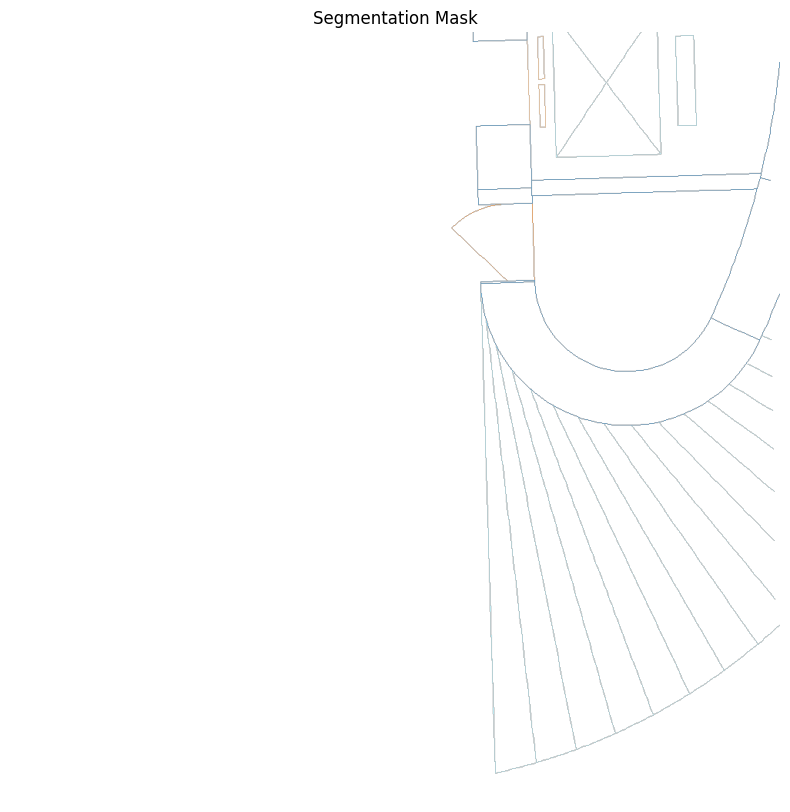

/tmp/ipykernel_3161/317562991.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(CLASS_MAP) + 1)


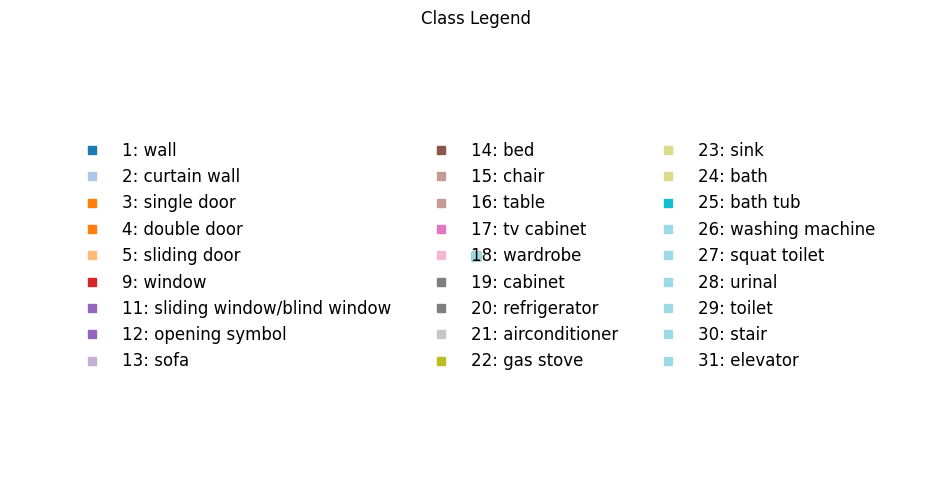

In [6]:
# Load and visualize a sample mask
def visualize_sample_mask(split="train-00"):
    """
    Visualize a sample mask from the specified split
    """
    mask_dir = os.path.join(PATHS["masks"], split)
    
    # Find PNG masks
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith(".png") and not f.endswith("_vis.png")]
    
    if not mask_files:
        print(f"No masks found in {mask_dir}")
        return
    
    # Load first mask
    sample_mask = cv2.imread(os.path.join(mask_dir, mask_files[0]), cv2.IMREAD_UNCHANGED)
    
    # Visualize
    plt.figure(figsize=(10, 10))
    
    # Create colored visualization
    visualize_mask(sample_mask)
    
    # Show class legend
    plt.figure(figsize=(10, 5))
    
    # Create legend patches
    cmap = plt.cm.get_cmap('tab20', len(CLASS_MAP) + 1)
    
    for i, (class_id, class_name) in enumerate(sorted(CLASS_MAP.items())):
        color = cmap(class_id)
        plt.plot(0, 0, "s", color=color, label=f"{class_id}: {class_name}")
    
    plt.legend(loc='center', ncol=3, frameon=False, fontsize=12)
    plt.axis('off')
    plt.title("Class Legend")
    plt.tight_layout()
    plt.show()

# Visualize sample mask if available
try:
    visualize_sample_mask()
except Exception as e:
    print(f"Error visualizing sample mask: {e}")